<table>
  <tr>
    <td><img src="https://github.com/rvss-australia/RVSS/blob/main/Pics/RVSS-logo-col.med.jpg?raw=1" width="400"></td>
    <td><div align="left"><font size="30">Finding blobs</font></div></td>
  </tr>
</table>

(c) Peter Corke 2024

Robotics, Vision & Control: Python, see section 12.1.3.4

## Configuring the Jupyter environment
We need to import some packages to help us with linear algebra (`numpy`), graphics (`matplotlib`), and machine vision (`machinevisiontoolbox`).
If you're running locally you need to have these packages installed.  If you're running on CoLab we have to first install machinevisiontoolbox which is not preinstalled, this will be a bit slow.

In [ ]:
try:
    import google.colab
    print("Running on CoLab")
    !pip install machinevision-toolbox-python
    COLAB = True
except:
    COLAB = False

%matplotlib ipympl
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams["figure.figsize"] = [8, 8]

import numpy as np
np.set_printoptions(linewidth=120, formatter={"float": lambda x: f"{x:8.4g}" if abs(x) > 1e-10 else f"{0:8.4g}"})

# display result of assignments
%config ZMQInteractiveShell.ast_node_interactivity = "last_expr_or_assign"

from machinevisiontoolbox import Image
from spatialmath import SE3
from spatialmath import base
import dot

open3d not installed


***

# Find objects in a binary image

We start by loading a binary image

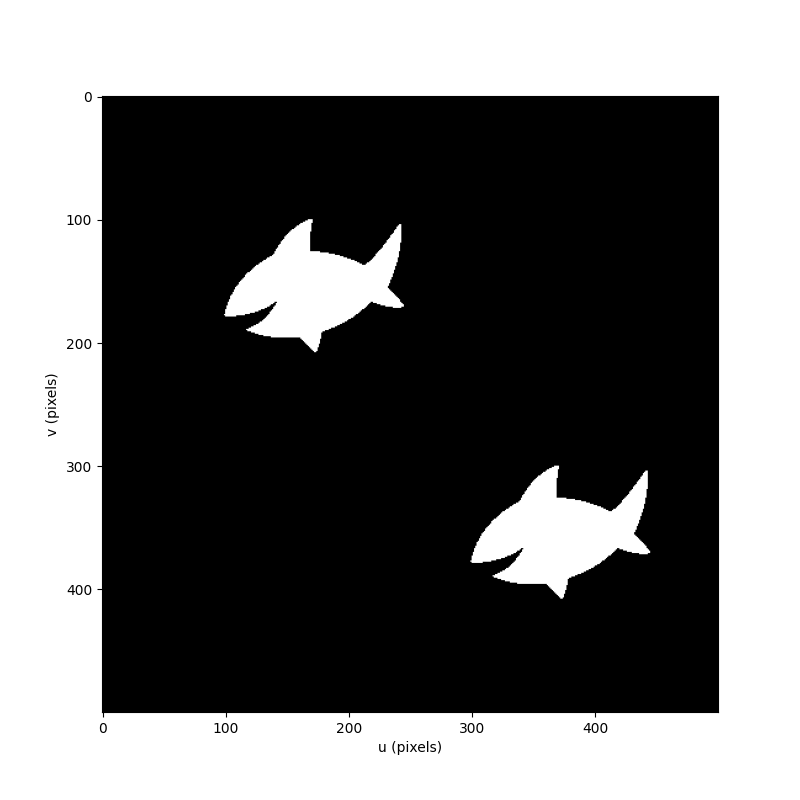

In [2]:
sharks = Image.Read("./shark2.png")
sharks.disp();

When we look at this we see two white objects, vaguely-shark shaped, against a black background.  But the *objects* are a mental construct of ours, the image is simply 250,000 black and white pixels.  How do group adjacent pixels of the same color to find the objects?

This is a very classical computer vision problem that goes by many names: blob analysis, connectivity analysis, region labelling and many more.
Such objects in a binary object are often called *blobs*.

Using this toolbox we simply write

In [3]:
blobs = sharks.blobs()

┌────┬────────┬──────────────┬──────────┬───────┬───────┬────────┬────────┬────────┐
│ id │ parent │     centroid │     area │ touch │ perim │ circul │ orient │ aspect │
├────┼────────┼──────────────┼──────────┼───────┼───────┼────────┼────────┼────────┤
│  0 │     -1 │ 371.2, 355.2 │ 7.59e+03 │ False │ 556.6 │  0.343 │ -11.7° │  0.584 │
│  1 │     -1 │ 171.2, 155.2 │ 7.59e+03 │ False │ 556.6 │  0.343 │ -11.7° │  0.584 │
└────┴────────┴──────────────┴──────────┴───────┴───────┴────────┴────────┴────────┘

The the result is a feature object that describes the *blobs* present in the scene.
In this case there are


In [4]:
len(blobs)

2

Each blob has a number of properties which are shown in the columns of the table.  Each blob has a unique `id` and a `parent` which will discuss later.

We can put a box around the blobs and label them with their `id` number.

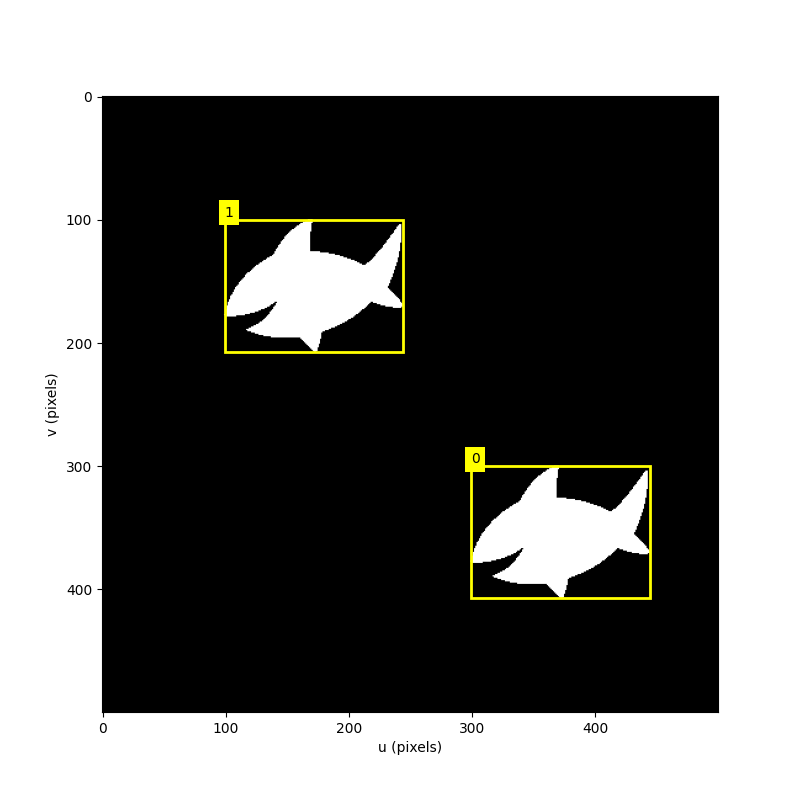

In [5]:
sharks.disp(block=None)
blobs.plot_labelbox(color="yellow", linewidth=2)

The background is also a blob, a black blob, but here we are ignoring that.

This `blobs` object can be indexed or sliced just like a list.  Each element has a number of properties which were listed in the table earlier.  For example, its centroid (centre of mass) is

In [6]:
blobs[0].centroid

(371.2073205542015, 355.18802011286033)

its area in pixels

In [7]:
blobs[0].area

7590.5

and a bounding box

In [8]:
blobs[0].bbox

array([299, 444, 300, 407])

where the first row is the u-axis range, and the second row is the v-axis range.  Alternatively we can consider the columns: the first column is the top-left coordinate and the second column is the bottom-right coordinate.

For each blob we can obtain the length of its perimeter

In [9]:
blobs[0].perimeter_length

556.5706294775009

as well as the perimeter, as a set of points

In [10]:
blobs[0].perimeter

array([[367, 366, 365, 364, 363, 362, 361, 360, 359, 358, 357, 356, 355, 354, 353, 352, 351, 350, 349, 348, 348, 347,
        346, 345, 345, 344, 343, 343, 342, 341, 341, 340, 340, 339, 338, 337, 336, 335, 334, 333, 332, 331, 330, 329,
        328, 327, 326, 325, 324, 323, 322, 321, 320, 319, 318, 317, 316, 316, 315, 314, 313, 312, 311, 311, 310, 309,
        308, 308, 307, 307, 306, 306, 305, 304, 304, 304, 303, 303, 302, 302, 302, 301, 301, 301, 300, 300, 300, 300,
        299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320,
        321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342,
        341, 341, 340, 339, 339, 338, 337, 336, 336, 335, 334, 333, 332, 331, 330, 329, 328, 327, 326, 325, 324, 323,
        322, 321, 320, 319, 318, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333,
        334, 335, 336, 337, 338, 339, 340, 341, 342, 343

A simple but useful measure of "shape" is circularity, computed from area and perimeter.  It is 1 for a circle and 0 for a line.

In [11]:
blobs[0].circularity

np.float64(0.34258515276788193)

These properties can also be computed on a list of blob objects, and the result is an array or list. For example

In [12]:
blobs.area

array([    7590,     7590])

In [13]:
blobs.centroid

[(371.2073205542015, 355.18802011286033),
 (171.20732055420152, 155.18802011286036)]

The blob objects also support some graphical operations.
which depicts and labels each blob.  We also marked the centroids.

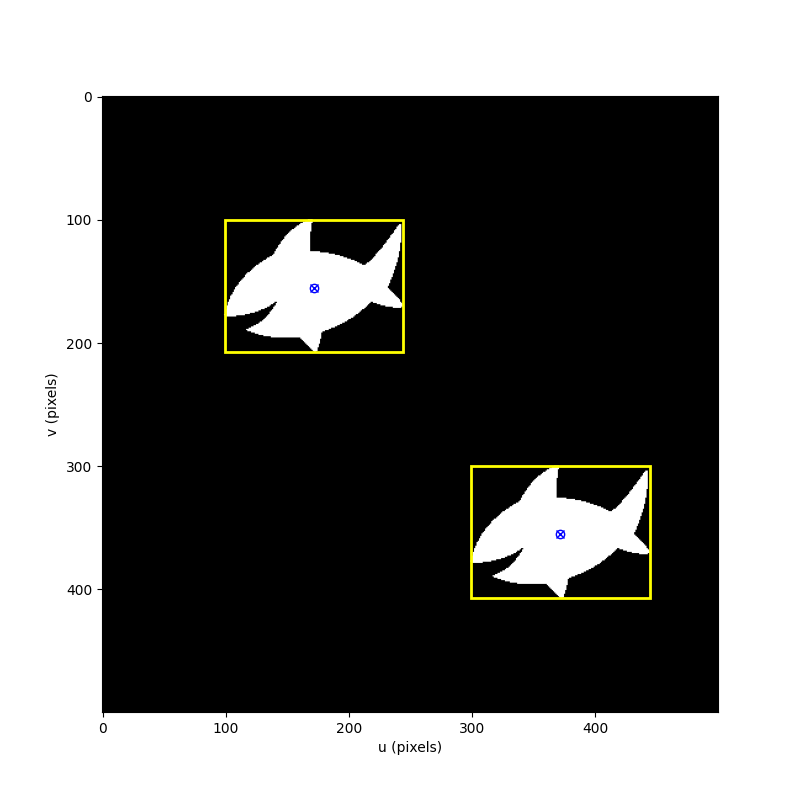

In [14]:
sharks.disp(block=None)
blobs.plot_box(color="yellow", linewidth=2)
blobs.plot_centroid()

Now we will load a more complex image that has blobs with holes that contain blobs with holes...

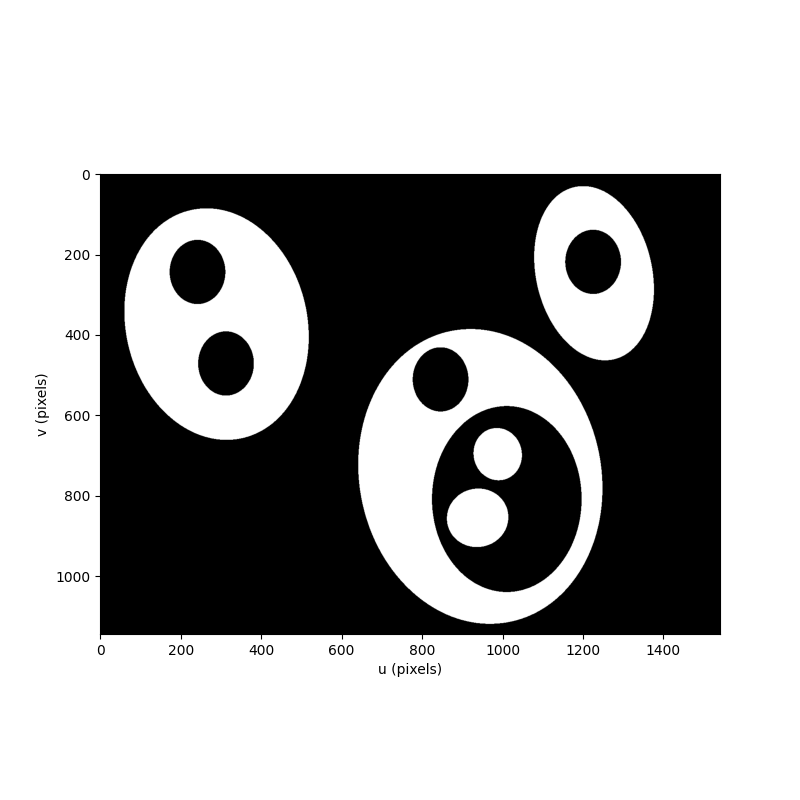

In [15]:
multi = Image.Read("multiblobs.png", grey=True)
multi.disp();

**Q: how many blobs are in this scene?**

We can find the blobs

In [16]:
blobs = multi.blobs()
len(blobs)

10

and display the parameters as a table

In [17]:
print(blobs)

┌────┬────────┬───────────────┬──────────┬───────┬────────┬────────┬─────────┬────────┐
│ id │ parent │      centroid │     area │ touch │  perim │ circul │  orient │ aspect │
├────┼────────┼───────────────┼──────────┼───────┼────────┼────────┼─────────┼────────┤
│  0 │     -1 │  907.9, 735.1 │ 1.75e+04 │ False │ 2219.0 │  0.551 │ -103.6° │  0.814 │
│  1 │      0 │ 1025.0, 813.7 │ 1.75e+04 │ False │ 1386.9 │  0.770 │  -90.0° │  0.802 │
│  2 │      1 │  938.1, 855.2 │ 1.75e+04 │ False │  489.7 │  1.005 │  -12.5° │  0.945 │
│  3 │      1 │  988.1, 697.2 │ 1.75e+04 │ False │  411.5 │  0.999 │ -102.8° │  0.919 │
│  4 │      0 │  846.0, 511.7 │ 1.75e+04 │ False │  495.9 │  0.996 │  -90.1° │  0.871 │
│  5 │     -1 │  291.7, 377.8 │ 1.75e+04 │ False │ 1711.6 │  0.811 │ -102.9° │  0.775 │
│  6 │      5 │  312.7, 472.1 │ 1.75e+04 │ False │  494.5 │  1.001 │  -90.2° │   0.87 │
│  7 │      5 │  241.9, 245.0 │ 1.75e+04 │ False │  495.9 │  0.996 │  -90.1° │  0.871 │
│  8 │     -1 │ 1228.0, 254.3 │ 

We note that this time some of the blobs have a parent that is not -1 (the background blob).  Looking at the figure we can see that there is some hierarchy of blobs -- a blob can have subblobs, which themselves can have subblobs.  We often refer to subblobs as **child** blobs, and they are contained within a **parent** blob.

The parent of blob 2 is

In [18]:
blobs[2].parent

1

And the children of blob 2 are

In [27]:
blobs[1].children

[2, 3]

The datastructure we need to represent this hierarchy is a tree.  If you have the `graphviz` package installed and the `dot` command-line utility then we can run

In [28]:
blobs.dotfile(show=True);

The final thing we will do is to create a label image and display it

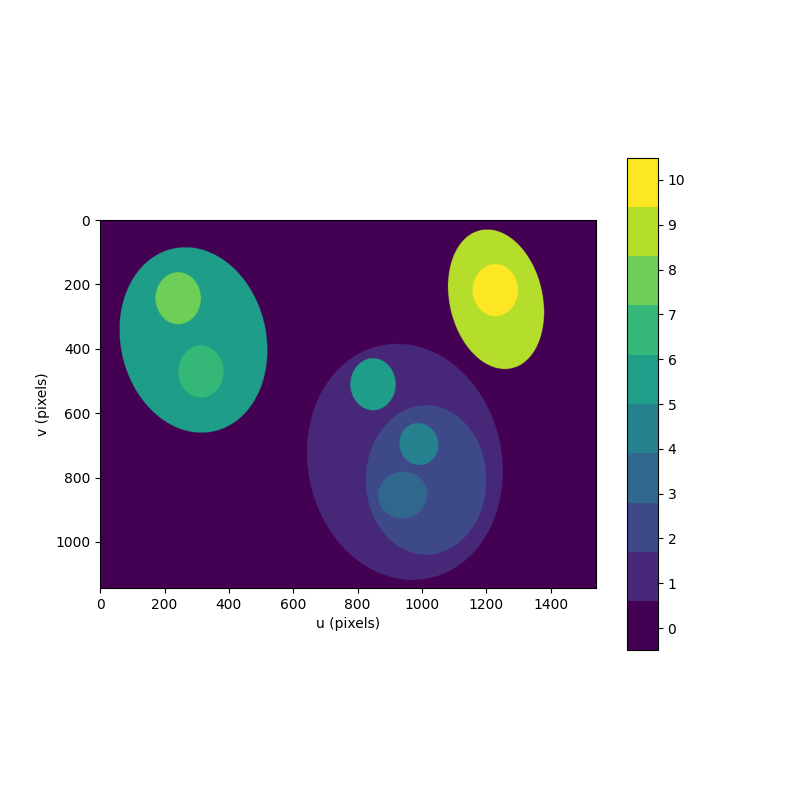

In [30]:
labels = blobs.label_image()
labels.disp(
    colormap="viridis",
    ncolors=10,
    colorbar=dict(shrink=0.8, aspect=20 * 0.8),
    block=True,
)

Where the value of each pixel is the `id` of the blob it belongs to.  By drifting the cursor over the image you can see which pixels belong to say blob #6.  The image uses a colorful colormap to make it easy to see the different label areas.